In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 

import torch # For building the networks 
import torchtuples as tt # Some useful functions

from pycox.datasets import metabric
from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv
from pycox.preprocessing.feature_transforms import OrderedCategoricalLong

In [2]:
np.random.seed(1234)
_ = torch.manual_seed(123)

## Dataset

In [3]:
df_train_x = pd.read_csv('train_x.csv')
df_train_y = pd.read_csv('train_y.csv')
df_train_y['Status'].replace({True: 1, False: 0}, inplace=True)

In [4]:
df_test_x = pd.read_csv('test_x.csv')
df_test_y = pd.read_csv('test_y.csv')
df_test_y['Status'].replace({True: 1, False: 0}, inplace=True)

In [5]:
df_test = pd.concat([df_test_x, df_test_y], axis=1)
df_test = df_test.astype('float32')

In [6]:
df_train = pd.concat([df_train_x, df_train_y], axis=1)
df_train = df_train.astype('float32')

In [7]:
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [8]:
cols_standardize =  ['BE', 'BC', 'AQ', 'Age'] # Numerical columns
cols_leave = ['Y', 'AF', 'BG', 'BH', 'BI', 'BL',
              'BM', 'BP', 'CY', 'DC', 'DT',
              'DW', 'DX', 'DY', 'metastasis', 'secondprim'] # Binary columns
cols_categorical =  ['AY', 'DE'] # Categorical Columns

print(len(cols_standardize) + len(cols_leave) + len(cols_categorical))

22


In [9]:
# Turn them to binary features (0, 1)
df_train[cols_leave] -= 1
df_val[cols_leave] -= 1
df_test[cols_leave] -= 1

In [10]:
df_train.head(4)

,Y,AF,AQ,AY,BC,BE,BG,BH,BI,BL,...,DE,DT,DW,DX,DY,Age,metastasis,secondprim,Status,Survival
0,0.0,1.0,2.0,2.0,6.7,3.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,75.0,1.0,1.0,1.0,363.0
1,1.0,0.0,2.0,3.0,1.5,2.0,0.0,0.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,66.0,1.0,1.0,0.0,10000.0
2,1.0,0.0,3.0,3.0,2.9,3.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,48.0,1.0,1.0,0.0,12.0
3,0.0,1.0,4.0,3.0,4.0,2.0,0.0,1.0,1.0,0.0,...,2.0,1.0,1.0,1.0,1.0,65.0,1.0,1.0,0.0,10000.0


## Feature transforms

In [11]:
# Preprocess different types of features.
standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]
categorical = [(col, OrderedCategoricalLong()) for col in cols_categorical]

x_mapper_float = DataFrameMapper(standardize + leave)
x_mapper_long = DataFrameMapper(categorical)  # we need a separate mapper to ensure the data type 'int64'

In [12]:
x_fit_transform = lambda df: tt.tuplefy(x_mapper_float.fit_transform(df), x_mapper_long.fit_transform(df))
x_transform = lambda df: tt.tuplefy(x_mapper_float.transform(df), x_mapper_long.transform(df))

In [13]:
x_train = x_fit_transform(df_train)
x_val = x_transform(df_val)
x_test = x_transform(df_test)

## Label transforms

In [35]:
num_durations = 20
labtrans = DeepHitSingle.label_transform(num_durations)
get_target = lambda df: (df['Survival'].values, df['Status'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

In [36]:
type(labtrans)

pycox.preprocessing.label_transforms.LabTransDiscreteTime

## Neural net

We make a neural net with `torch`.
For simple network structures, we can use the `MLPVanilla` provided by `torchtuples`.
For building more advanced network architectures, see for example [the tutorials by PyTroch](https://pytorch.org/tutorials/).

The following net is an MLP with two hidden layers (with 32 nodes each), ReLU activations, and `num_nodes` output nodes.
We also have batch normalization and dropout between the layers.

In [37]:
num_embeddings = x_train[1].max(0) + 1
embedding_dims = num_embeddings // 2

In [38]:
num_embeddings, embedding_dims

(array([3, 4], dtype=int64), array([1, 2], dtype=int64))

In [68]:
in_features = x_train[0].shape[1]
out_features = labtrans.out_features
num_nodes = [32, 32]
batch_norm = True
dropout = 0.1

net = tt.practical.MixedInputMLP(in_features, num_embeddings, embedding_dims,
                                 num_nodes, out_features, batch_norm, dropout)

In [69]:
net

MixedInputMLP(
  (embeddings): EntityEmbeddings(
    (embeddings): ModuleList(
      (0): Embedding(3, 1)
      (1): Embedding(4, 2)
    )
  )
  (mlp): MLPVanilla(
    (net): Sequential(
      (0): DenseVanillaBlock(
        (linear): Linear(in_features=23, out_features=32, bias=True)
        (activation): ReLU()
        (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): DenseVanillaBlock(
        (linear): Linear(in_features=32, out_features=32, bias=True)
        (activation): ReLU()
        (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (2): Linear(in_features=32, out_features=20, bias=True)
    )
  )
)

## Training the model

In [70]:
model = DeepHitSingle(net, tt.optim.Adam, alpha=0.2, sigma=0.1, duration_index=labtrans.cuts)

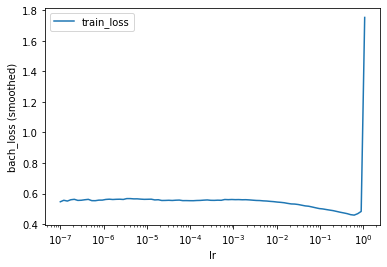

In [71]:
batch_size = 256
lr_finder = model.lr_finder(x_train, y_train, batch_size, tolerance=3)
_ = lr_finder.plot()

In [72]:
lr_finder.get_best_lr()

0.0613590727341321

Often, this learning rate is a little high, so we instead set it manually to 0.01

In [73]:
model.optimizer.set_lr(0.02)

We include the `EarlyStopping` callback to stop training when the validation loss stops improving. After training, this callback will also load the best performing model in terms of validation loss.

In [74]:
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 0.4863,	val_loss: 0.4591
1:	[0s / 0s],		train_loss: 0.4152,	val_loss: 0.4613
2:	[0s / 0s],		train_loss: 0.4410,	val_loss: 0.4421
3:	[0s / 0s],		train_loss: 0.3603,	val_loss: 0.4242
4:	[0s / 0s],		train_loss: 0.4360,	val_loss: 0.4174
5:	[0s / 0s],		train_loss: 0.3409,	val_loss: 0.4157
6:	[0s / 0s],		train_loss: 0.3354,	val_loss: 0.4132
7:	[0s / 0s],		train_loss: 0.3256,	val_loss: 0.4139
8:	[0s / 0s],		train_loss: 0.3161,	val_loss: 0.4227
9:	[0s / 0s],		train_loss: 0.2588,	val_loss: 0.4514
10:	[0s / 0s],		train_loss: 0.2296,	val_loss: 0.5490
11:	[0s / 0s],		train_loss: 0.2246,	val_loss: 0.7666
12:	[0s / 0s],		train_loss: 0.2161,	val_loss: 1.1051
13:	[0s / 0s],		train_loss: 0.2826,	val_loss: 1.5171
14:	[0s / 0s],		train_loss: 0.1864,	val_loss: 2.2747
15:	[0s / 0s],		train_loss: 0.1850,	val_loss: 3.2446
16:	[0s / 0s],		train_loss: 0.1817,	val_loss: 3.4047


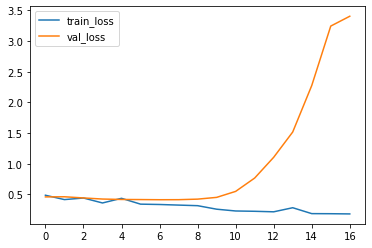

In [75]:
_ = log.plot()

## Prediction

In [76]:
surv = model.predict_surv_df(x_test)

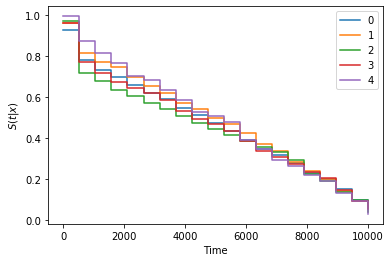

In [77]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('$S(t|x)$')
_ = plt.xlabel('Time')

In [78]:
surv = model.interpolate(10).predict_surv_df(x_test)

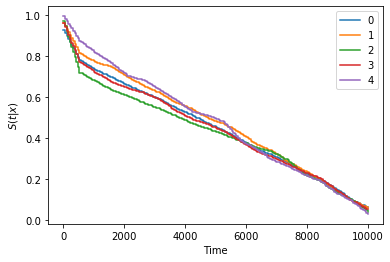

In [79]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('$S(t|x)$')
_ = plt.xlabel('Time')

## Evaluation

In [80]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [84]:
durations_train, events_train = get_target(df_train)

In [85]:
surv_train = model.interpolate(100).predict_surv_df(x_train)

In [86]:
ev_train = EvalSurv(surv_train, durations_train, events_train, censor_surv='km')

In [87]:
ev_train.concordance_td()

0.7926937008569661

#### Concordance

In [81]:
ev.concordance_td()

0.7673860911270983

#### Brier Score

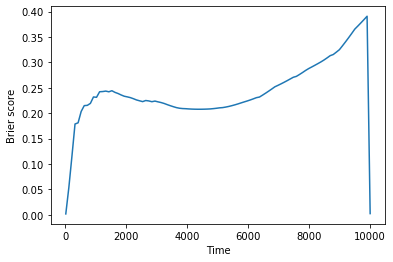

In [82]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

#### Integrated scores

In [83]:
ev.integrated_brier_score(time_grid) 

0.24399712660729564

In [88]:
ev_train.integrated_brier_score(time_grid) 

0.245243648829662